In [1]:
## Notebook contains:
## Unsupervised learning techniques to detect fraud 
## Core dimensionality reduction algorithms are used to detect suspicious/anomalous occurrences in our data

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import sys
import datetime 
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.decomposition import PCA, SparsePCA, KernelPCA, MiniBatchDictionaryLearning, FastICA
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- **“Time”: Number of seconds elapsed between the transaction in question and the first transaction carried out by a credit card user**
- **“V1” ~ “V28”: Output of a PCA dimensionality reduction on original raw data to protect user identities and sensitive information**
- **“Amount”: Transaction amount**
- **“Class”: 1 stands for fraud, 0 otherwise**

In [4]:
#Dataset details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- All details of the cardholders have been anonymized via a principal component analysis (PCA) transform
- Over 280,000 records and 31 features without any null or missing values

In [5]:
## descriptive statistics
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# fraud vs. normal transactions 
counts = df.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100
print('There are {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%).'.format(normal, perc_normal, fraudulent, perc_fraudulent))

There are 284315 non-fraudulent transactions (99.827%) and 492 fraudulent transactions (0.173%).


**There's severe skew in the class distribution, with about 99.827 percent of transactions marked as normal and about 0.173 percent marked as fraudulent**

In [7]:
# analysing the average transaction amount in fraud vs valid
Fraud = df[df['Class'] == 1]
Valid = df[df['Class'] == 0]

print('Amount details of fraudulent transaction')
Fraud.Amount.describe()

Amount details of fraudulent transaction


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [8]:
print('Amount details of valid transaction')
Valid.Amount.describe()

Amount details of valid transaction


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

The average money transaction for the fraudulent ones are more which makes this problem crucial to deal with.

Text(0.5, 1.0, 'Heatmap Showcasing Correlation')

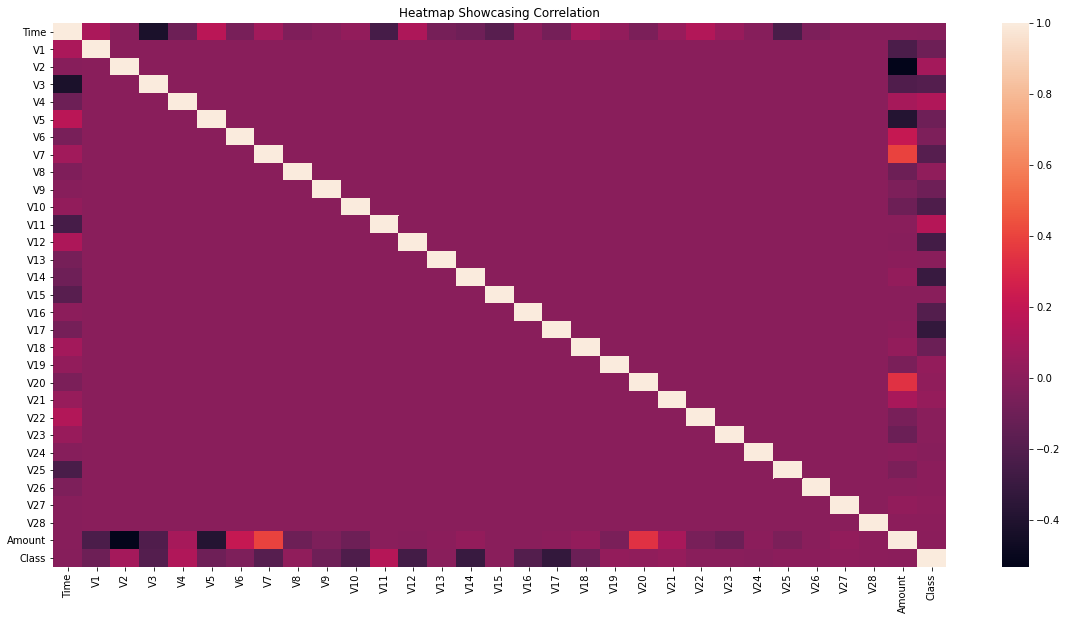

In [9]:
#Correlation between the features
plt.figure(figsize=(20,10))
sns.heatmap(df.corr())
plt.title('Heatmap Showcasing Correlation')

Most of the features do not correlate to other features but there are some features that either has a positive or a negative correlation with each other. For example, "V2" and "V5" are highly negatively correlated with  "Amount".

<AxesSubplot:xlabel='Class', ylabel='V17'>

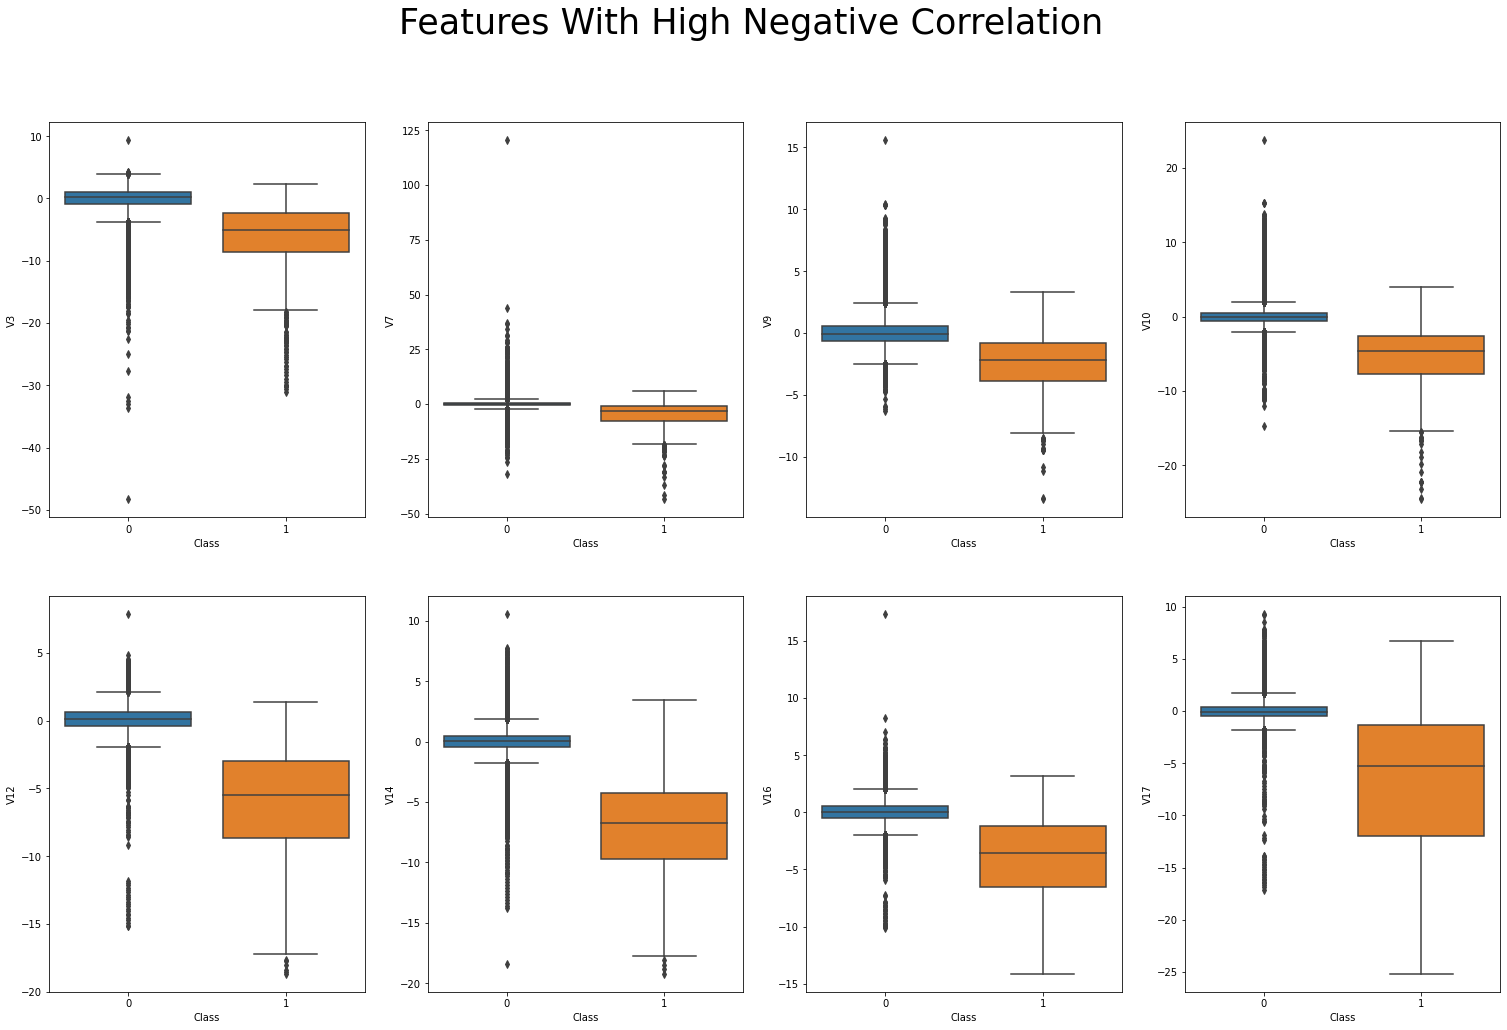

In [10]:
# visualizing the features having high negative correlation with class
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(26,16))

f.suptitle('Features With High Negative Correlation', size=35)
sns.boxplot(x="Class", y="V3", data=df, ax=axes[0,0])
sns.boxplot(x="Class", y="V7", data=df, ax=axes[0,1])
sns.boxplot(x="Class", y="V9", data=df, ax=axes[0,2])
sns.boxplot(x="Class", y="V10", data=df, ax=axes[0,3])
sns.boxplot(x="Class", y="V12", data=df, ax=axes[1,0])
sns.boxplot(x="Class", y="V14", data=df, ax=axes[1,1])
sns.boxplot(x="Class", y="V16", data=df, ax=axes[1,2])
sns.boxplot(x="Class", y="V17", data=df, ax=axes[1,3])

In [11]:
# separating input features and class labels
x = df.drop(['Class'],axis=1)
y = df['Class']

In [12]:
# scaling features
featuresToScale = x.columns
scaler = StandardScaler()
x.loc[:,featuresToScale] = scaler.fit_transform(x[featuresToScale])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33,  random_state=2018, stratify=y)

Note: `stratify` parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to the parameter stratify.

### Anomaly Score

Dimensionality reduction algorithms reduce the dimensionality of data while attempting to minimize the reconstruction error. In other words, these algorithms try to capture the most salient information of the original features in such a way that they can reconstruct the original feature set from the reduced feature set as well as possible. However, these dimensionality reduction algorithms cannot capture all the information of the original features as they move to a lower dimensional space; therefore, there will be some error as these algorithms reconstruct the reduced feature set back to the original number of dimensions.

In the context of our credit card transactions dataset, the algorithms will have the largest reconstruction error on those transactions that are hardest to model — in other words, those that occur the least often are the most anomalous. Since fraud is rare and presumably different than normal transactions, the fraudulent transactions should exhibit the largest reconstruction error. So let’s define `the anomaly score as the reconstruction error`.

The reconstruction error for each transaction is `the sum of the squared differences between the original feature matrix and the reconstructed matrix using the dimensionality reduction algorithm`. We will scale the sum of the squared differences by the max-min range of the sum of the squared differences for the entire dataset, so that all the reconstruction errors are within a zero to one range.

`The transactions that have the largest sum of squared differences will have an error close to one, while those that have the smallest sum of squared differences will have an error close to zero.`

### Define Anomaly Score Function

Defining a function that calculates how anomalous each transaction is. The more anomalous the transaction is, the more likely it is to be fraudulent, assuming that fraud is rare and looks somewhat different than the majority of transactions, which are normal.

In [14]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

### Define Evaluation Metrics

We will use the "Class" labels to evaluate the unsupervised solutions we develop. The labels will help us understand just how well these solutions are at catching known patterns of fraud.

In [15]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

### Define Plotting Function

We will use the scatterplot function to display the separation of points the dimensionality reduction algorithm achieves in just the first two dimensions.

In [16]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

### Normal PCA Anomaly Detection

We will now use PCA to learn the underlying structure of the credit card transactions. Once we learn this structure, we will use the learned model to reconstruct the credit card transactions and then calculate how different the reconstructed transactions are from the original transactions. Those transactions that PCA does the poorest job of reconstructing are the most anomalous (and most likely to be fraudulent).

`Note: The features in the credit card transactions dataset we have are already the output of PCA. However, there is nothing unusual about performing PCA for anomaly detection on an already dimensionality-reduced dataset. We just treat the original principal components that we are given as the original features.`

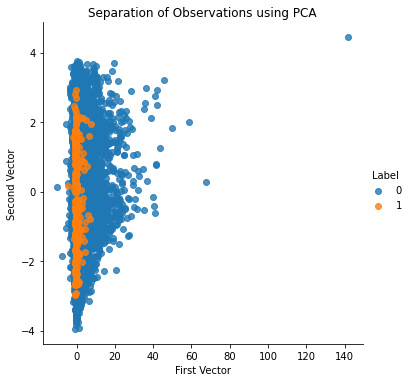

In [17]:
pca = PCA(n_components=30, whiten=False, random_state=2018)

x_train_PCA = pca.fit_transform(x_train)
x_train_PCA = pd.DataFrame(data=x_train_PCA, index=x_train.index)

x_train_PCA_inverse = pca.inverse_transform(x_train_PCA)
x_train_PCA_inverse = pd.DataFrame(data=x_train_PCA_inverse, index=x_train.index)

scatterPlot(x_train_PCA, y_train, "PCA")

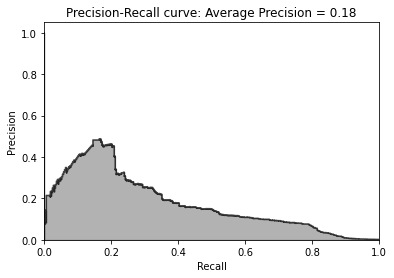

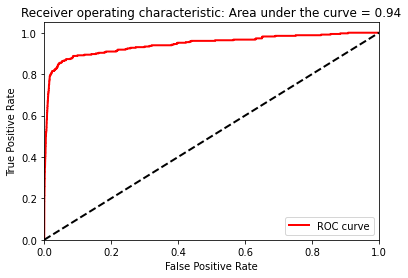

In [18]:
anomalyScoresPCA = anomalyScores(x_train, x_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

With an average precision of 0.11, this is a poor fraud detection solution.

### Search for the Optimal Number of Principal Components

Let’s perform a few experiments by reducing the number of principal components that PCA generates and evaluate the fraud detection results. We need the PCA-based fraud detection solution to have enough error on the rare cases that it can meaningfully separate fraud cases from the normal ones. But the error cannot be so low or so high for all the transactions that the rare and normal transactions are virtually indistinguishable.

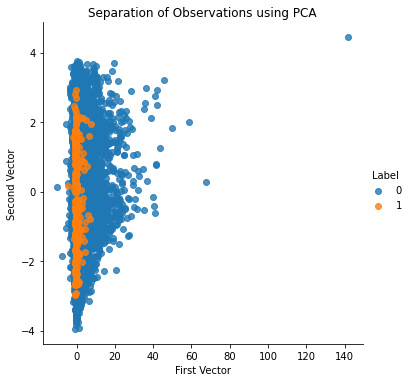

In [19]:
# 27 principal components
pca = PCA(n_components=27, whiten=False, random_state=2018)

x_train_PCA = pca.fit_transform(x_train)
x_train_PCA = pd.DataFrame(data=x_train_PCA, index=x_train.index)

x_train_PCA_inverse = pca.inverse_transform(x_train_PCA)
x_train_PCA_inverse = pd.DataFrame(data=x_train_PCA_inverse, index=x_train.index)

scatterPlot(x_train_PCA, y_train, "PCA")

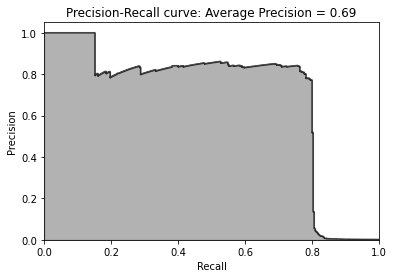

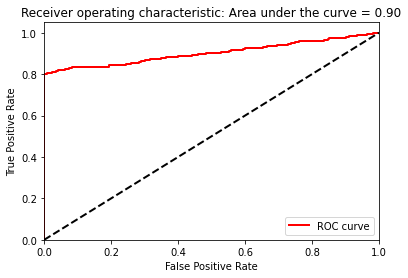

In [20]:
# View plot
anomalyScoresPCA = anomalyScores(x_train, x_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

With 27 principal components, we are able to catch 80% of the fraud with 75% precision. This is very impressive considering that we did not use any labels. 

In [21]:
# Analyze results
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.75
Recall:  0.8
Fraud Caught out of 330 Cases: 264


Using PCA, we calculated the reconstruction error for each of the 190,820 transactions in the train set. If we sort these transactions by highest reconstruction error (also referred to as anomaly score) in descending order and extract the top 350 transactions from the list, we can see that 264 of these transactions are fraudulent.

That is a precision of 75%. Moreover, the 264 transactions we caught from the 350 we picked represent 80% of the total fraud in the training set (264 out of 330 fraudulent cases). 

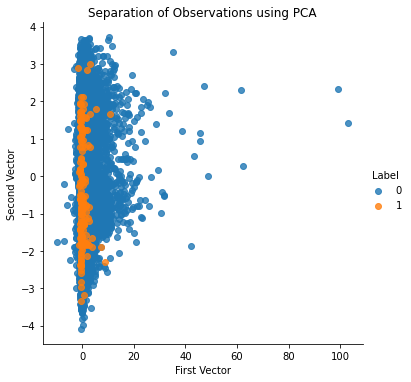

In [22]:
# PCA on Test Set
x_test_PCA = pca.transform(x_test)
x_test_PCA = pd.DataFrame(data=x_test_PCA, index=x_test.index)

x_test_PCA_inverse = pca.inverse_transform(x_test_PCA)
x_test_PCA_inverse = pd.DataFrame(data=x_test_PCA_inverse, index=x_test.index)

scatterPlot(x_test_PCA, y_test, "PCA")

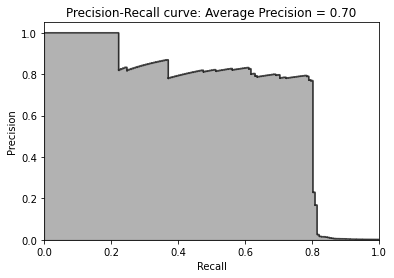

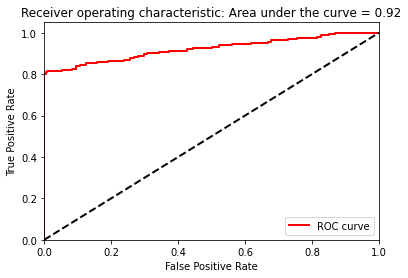

In [23]:
# View plot
anomalyScoresPCA = anomalyScores(x_test, x_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

We are able to catch 80% of the known fraud in the test set with an 80% precision.

### Sparse PCA Anomaly Detection

The normal PCA algorithm searches for linear combinations in all the input variables, reducing the original feature space as densely as possible. But for some machine learning problems, some degree of sparsity may be preferred. A version of PCA that retains some degree of sparsity — controlled by a hyperparameter called alpha — is known as sparse PCA. The sparse PCA algorithm searches for linear combinations in just some of the input variables, reducing the original feature space to some degree but not as compactly as normal PCA.
Sparse PCA is similar to normal PCA but delivers a less dense version; in other words, sparse PCA provides a sparse representation of the principal components.

We still need to specify the number of principal components we desire, but we must also set the alpha parameter, which controls the degree of sparsity. We will experiment with different values for the principal components and the alpha parameter as we search for the optimal sparse PCA fraud detection solution.

Follow the below link for further details on sparse PCA:
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html

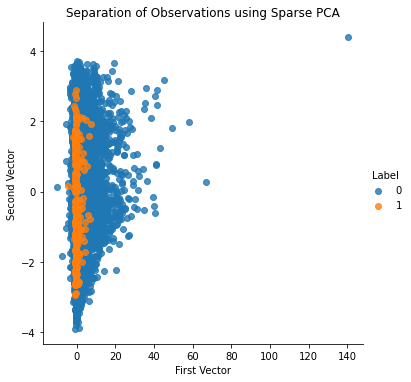

In [24]:
# Sparse PCA
sparsePCA = SparsePCA(n_components=27, alpha=0.0001, random_state=2018, n_jobs=-1)

sparsePCA.fit(x_train.loc[:,:])
x_train_sparsePCA = sparsePCA.transform(x_train)
x_train_sparsePCA = pd.DataFrame(data=x_train_sparsePCA, index=x_train.index)

scatterPlot(x_train_sparsePCA, y_train, "Sparse PCA")

Note: For normal PCA Scikit-Learn used a fit_transform function to generate the principal components and an inverse_transform function to reconstruct the original dimensions from the principal components. Using these two functions, we were able to calculate the reconstruction error between the original feature set and the reconstructed feature set derived from the PCA.

Unfortunately, Scikit-Learn does not provide an inverse_transform function for sparse PCA. Therefore, we must reconstruct the original dimensions after we perform sparse PCA ourselves.

Now let’s generate the original dimensions from the sparse PCA matrix by simple matrix multiplication of the sparse PCA matrix (with 190,820 samples and 27 dimensions) and the sparse PCA components (a 27 x 30 matrix), provided by Scikit-Learn library. This creates a matrix that is the original size (a 190,820 x 30 matrix). We also need to add the mean of each original feature to this new matrix.

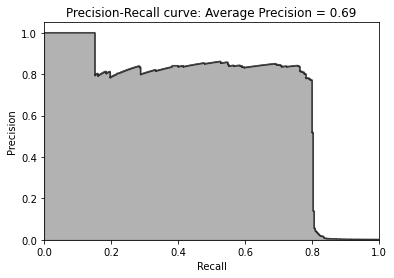

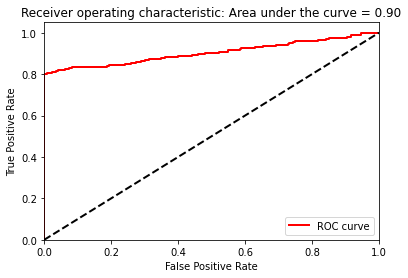

In [25]:
x_train_sparsePCA_inverse = np.array(x_train_sparsePCA).dot(sparsePCA.components_) + np.array(x_train.mean(axis=0))
x_train_sparsePCA_inverse = pd.DataFrame(data=x_train_sparsePCA_inverse, index=x_train.index)

# Plotting anomaly scores
anomalyScoresSparsePCA = anomalyScores(x_train, x_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

The results are identical to those of normal PCA. This is expected since normal and sparse PCA are very similar — the latter is just a sparse representation of the former.

You may experiment by changing the number of principal components generated and the alpha parameter, but, based on our experimentation, this is the best sparse PCA-based fraud detection solution.

### Kernel PCA Anomaly Detection

Normal PCA and sparse PCA linearly project the original data onto a lower dimensional space, but there is also a nonlinear form of PCA known as kernel PCA, which runs a similarity function over pairs of original data points in order to perform nonlinear dimensionality reduction.

By using this similarity function (known as the kernel method), kernel PCA maps the implicit feature space where the majority of data points lie and creates this implicit feature space in a much smaller number of dimensions than the dimensions in the original feature set. This method is especially effective when the original feature set is not linearly separable.

Kernel PCA is useful if the fraud transactions are not linearly separable from the nonfraud transactions.

We need to specify the number of components we would like to generate, the kernel (we will use the RBF kernel), and the gamma (which is set to 1/n_features by default, so 1/30 in our case). We also need to set the fit_inverse_transform to true to apply the built-in inverse_transform function provided by Scikit-Learn.

Finally, because kernel PCA is so expensive to train with, we will train on just the first two thousand samples in the transactions dataset. This is not ideal but it is necessary to perform experiments quickly.

We will use this training to transform the entire training set and generate the principal components. Then, we will use the inverse_transform function to recreate the original dimension from the principal components derived by kernel PCA.

Refer the sklearn documentation page for more info:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html

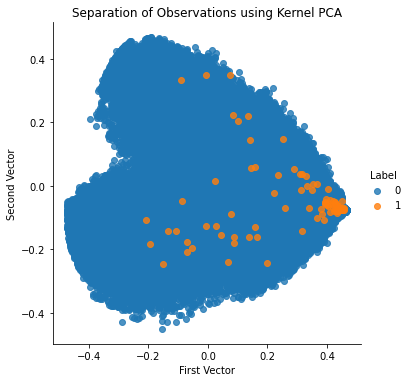

In [26]:
# Kernel PCA
kernelPCA = KernelPCA(n_components=27, kernel='rbf', gamma=None, fit_inverse_transform=True, n_jobs=-1, random_state=2018)

kernelPCA.fit(x_train.iloc[:2000])
x_train_kernelPCA = kernelPCA.transform(x_train)
x_train_kernelPCA = pd.DataFrame(data=x_train_kernelPCA, index=x_train.index)

x_train_kernelPCA_inverse = kernelPCA.inverse_transform(x_train_kernelPCA)
x_train_kernelPCA_inverse = pd.DataFrame(data=x_train_kernelPCA_inverse, index=x_train.index)

scatterPlot(x_train_kernelPCA, y_train, "Kernel PCA")

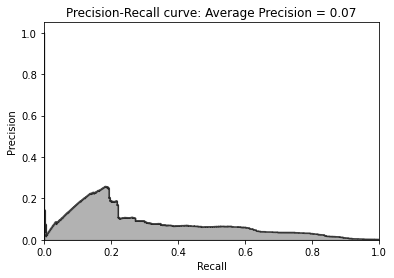

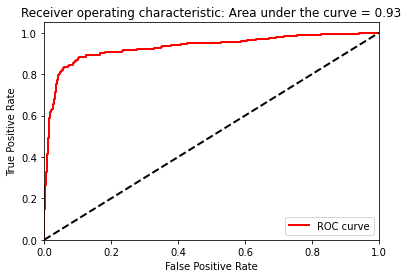

In [27]:
# View plot
anomalyScoresKernelPCA = anomalyScores(x_train, x_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresKernelPCA, True)

The results are far worse than those for normal PCA and sparse PCA. While it was worth experimenting with kernel PCA, we will not use this solution for fraud detection given that we have better performing solutions from before.

### Random Projection

In mathematics and statistics, random projection is a technique used to reduce the dimensionality of a set of points which lie in Euclidean space. Random projection methods are known for their power, simplicity and low error rates when compared to other methods. According to experimental results, random projection preserves distances well but empirical results are sparse.

Random projection is a simple and computationally efficient way to reduce the dimensionality of data by trading a controlled amount of error for faster processing times and smaller model sizes. The dimensions and distribution of random projection matrices are controlled so as to approximately preserve the pairwise distances between any two samples of the dataset.

The core idea behind random projection is given in the Johnson-Lindenstrauss lemma which states that if points in a vector space are of sufficiently high dimension, then they may be projected into a suitable lower-dimensional space in a way which approximately preserves the distances between the points. One of the explanations of this effect is the exponentially high quasiorthogonal dimension of n-dimensional Euclidean space. There are exponentially large (in dimension n) sets of almost orthogonal vectors (with small value of inner products) in n–dimensional Euclidean space. This observation is useful in indexing of high-dimensional data.

Quasiorthogonality of large random sets is important for methods of random approximation in machine learning. In high dimensions, exponentially large numbers of randomly and independently chosen vectors from equidistribution on a sphere (and from many other distributions) are almost orthogonal with probability close to one. This implies that in order to represent an element of such a high-dimensional space by linear combinations of randomly and independently chosen vectors, it may often be necessary to generate samples of exponentially large length if we use bounded coefficients in linear combinations. On the other hand, if coefficients with arbitrarily large values are allowed, the number of randomly generated elements that are sufficient for approximation is even less than dimension of the data space.


### Gaussian Random Projection Anomaly Detection

The Gaussian Random Projection reduces the dimensionality by projecting the original input space on a randomly generated matrix where components are drawn from the following distribution N(0,1/n-components).

https://scikit-learn.org/stable/modules/random_projection.html#:~:text=2.-,Gaussian%20random%20projection,n%20e%20n%20t%20s%20)%20.

Now, let’s try to develop a fraud detection solution using Gaussian random projection. We can set either the number of components we want or the eps parameter, which controls the quality of the embedding derived based on the Johnson–Lindenstrauss lemma.

We will choose to explicitly set the number of components. Gaussian random projection trains very quickly, so we can train on the entire training set.

As with sparse PCA, we will need to derive our own inverse_transform function because none is provided by Scikit-Learn.

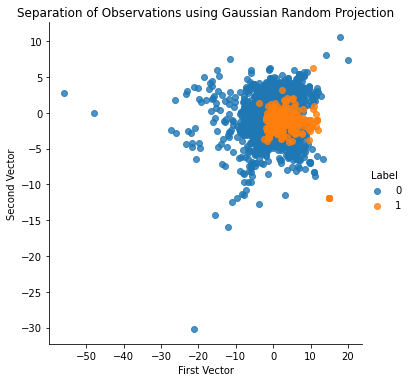

In [28]:
GRP = GaussianRandomProjection(n_components=27, eps=None, random_state=2018)

x_train_GRP = GRP.fit_transform(x_train)
x_train_GRP = pd.DataFrame(data=x_train_GRP, index=x_train.index)

scatterPlot(x_train_GRP, y_train, "Gaussian Random Projection")

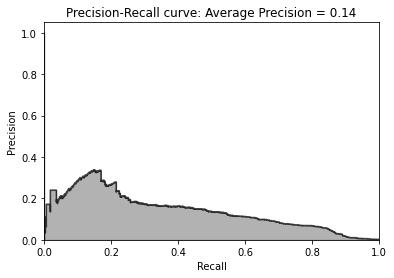

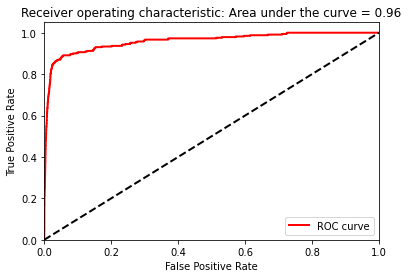

In [29]:
# View plot
x_train_GRP_inverse = np.array(x_train_GRP).dot(GRP.components_)
x_train_GRP_inverse = pd.DataFrame(data=x_train_GRP_inverse, index=x_train.index)

anomalyScoresGRP = anomalyScores(x_train, x_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresGRP, True)


These results are subpar, so we won’t use Gaussian random projection for fraud detection.

### Sparse Random Projection Anomaly Detection

The Sparse Random Projection reduces the dimensionality by projecting the original input space using a sparse random matrix.
Sparse random matrices are an alternative to dense Gaussian random projection matrix that guarantees similar embedding quality while being much more memory efficient and allowing faster computation of the projected data.

http://scikit-learn.org/stable/modules/generated/sklearn.random_projection.SparseRandomProjection.html

Let’s try to design a fraud detection solution using sparse random projection. We will designate the number of components we want (instead of setting the eps parameter). And, like with Gaussian random projection, we will use our own inverse_transform function to create the original dimensions from the sparse random projection-derived components.

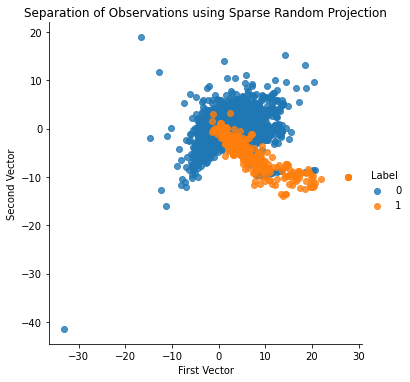

In [30]:
SRP = SparseRandomProjection(n_components=27, density='auto', eps=0.01, dense_output=True, random_state=2018)

x_train_SRP = SRP.fit_transform(x_train)
x_train_SRP = pd.DataFrame(data=x_train_SRP, index=x_train.index)

scatterPlot(x_train_SRP, y_train, "Sparse Random Projection")

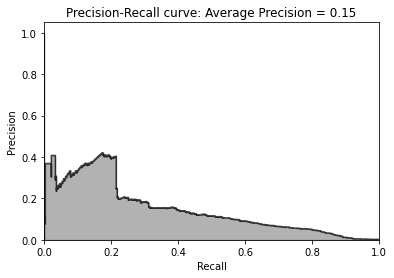

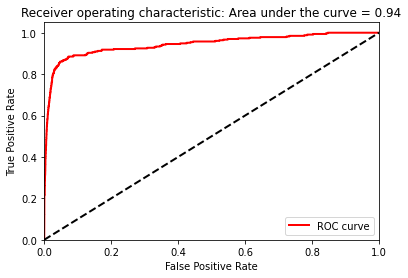

In [31]:
# View plot
x_train_SRP_inverse = np.array(x_train_SRP).dot(SRP.components_.todense())
x_train_SRP_inverse = pd.DataFrame(data=x_train_SRP_inverse, index=x_train.index)

anomalyScoresSRP = anomalyScores(x_train, x_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

Similar to Gaussian Random Projection, Sparse Random Projection is yielding poor results as well

### Dictionary Learning Anomaly Detection

Dictionary learning learns the sparse representation of the original data. The resulting matrix is known as the dictionary, and the vectors in the dictionary are known as atoms.

Assuming there are d features in the original data and n atoms in the dictionary, we can have a dictionary that is either undercomplete, where n < d, or overcomplete, where n > d. The undercomplete dictionary achieves dimensionality reduction, representing the original data with a fewer number of vectors.

In dictionary learning, the algorithm learns the sparse representation of the original data. Using the vectors in the learned dictionary, each instance in the original data can be reconstructed as a weighted sum of these learned vectors.


For anomaly detection, we want to learn an undercomplete dictionary so that the vectors in the dictionary are fewer in number than the original dimensions. With this constraint, it will be easier to reconstruct the more frequently occurring normal transactions and much more difficult to construct the rarer fraud transactions.

In our case, we will generate 28 vectors (or components). To learn the dictionary, we will feed in 10 batches, where each batch has 200 samples.

We will need to use our own inverse_transform function too.

Refer the documentation page for more insight:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.MiniBatchDictionaryLearning.html

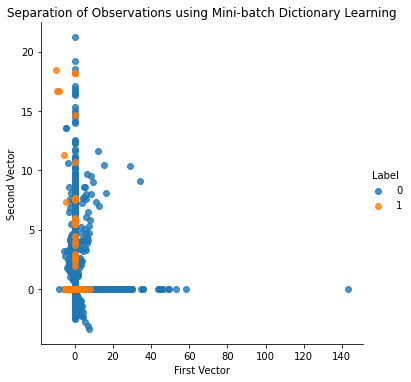

In [32]:
# Mini-batch dictionary learning
from sklearn.decomposition import MiniBatchDictionaryLearning

miniBatchDictLearning = MiniBatchDictionaryLearning( n_components=28, alpha=1, batch_size=200, n_iter=10, random_state=2018)

miniBatchDictLearning.fit(x_train)
x_train_miniBatchDictLearning =  miniBatchDictLearning.fit_transform(x_train)
x_train_miniBatchDictLearning = pd.DataFrame(data=x_train_miniBatchDictLearning, index=x_train.index)

scatterPlot(x_train_miniBatchDictLearning, y_train, "Mini-batch Dictionary Learning")

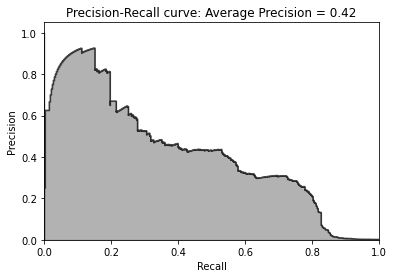

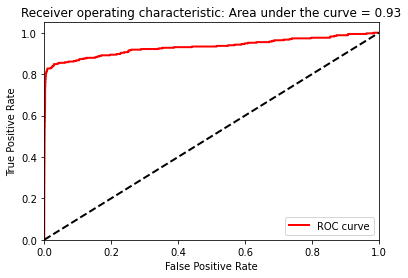

In [33]:
# View plot
x_train_miniBatchDictLearning_inverse = np.array(x_train_miniBatchDictLearning).dot(miniBatchDictLearning.components_)

x_train_miniBatchDictLearning_inverse = pd.DataFrame(data=x_train_miniBatchDictLearning_inverse, index=x_train.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(x_train, x_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train, anomalyScoresMiniBatchDictLearning, True)

The results are much better than those for kernal PCA but are no match for those of normal PCA. So far, PCA remains the best fraud detection solution for this credit card transactions dataset.

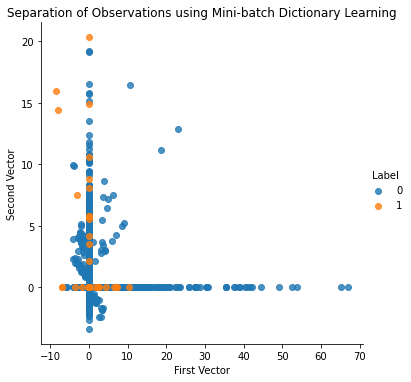

In [34]:
# Mini-batch dictionary learning on test set
x_test_miniBatchDictLearning = miniBatchDictLearning.transform(x_test)
x_test_miniBatchDictLearning = pd.DataFrame(data=x_test_miniBatchDictLearning, index=x_test.index)

scatterPlot(x_test_miniBatchDictLearning, y_test, "Mini-batch Dictionary Learning")

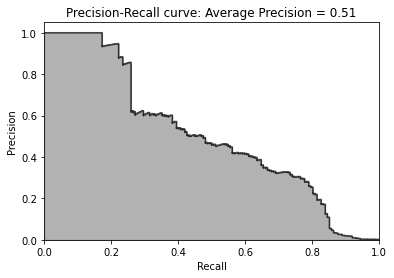

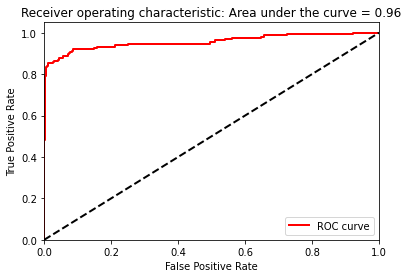

In [35]:
# View plot
x_test_miniBatchDictLearning_inverse = np.array(x_test_miniBatchDictLearning).dot(miniBatchDictLearning.components_)

x_test_miniBatchDictLearning_inverse = pd.DataFrame(data=x_test_miniBatchDictLearning_inverse, index=x_test.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(x_test, x_test_miniBatchDictLearning_inverse)
preds = plotResults(y_test, anomalyScoresMiniBatchDictLearning, True)

While the results are not terrible — we can catch 80% of the fraud with a 20% precision — they fall far short of the results from normal PCA.

### ICA Anomaly Detection

One common problem with unlabeled data is that there are many independent signals embedded together into the features we are given. Using independent component analysis (ICA), we can separate these blended signals into their individual components. After the separation is complete, we can reconstruct any of the original features by adding together some combination of the individual components we generate. ICA is commonly used in signal processing tasks.

For more details, refer:
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

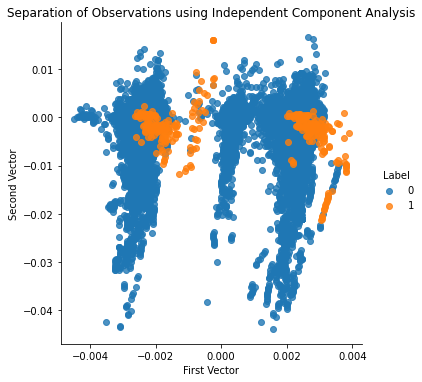

In [36]:
# Independent Component Analysis
from sklearn.decomposition import FastICA

fastICA = FastICA(n_components=27, algorithm='parallel', whiten=True, max_iter=200, random_state=2018)

x_train_fastICA = fastICA.fit_transform(x_train)
x_train_fastICA = pd.DataFrame(data=x_train_fastICA, index=x_train.index)

x_train_fastICA_inverse = fastICA.inverse_transform(x_train_fastICA)
x_train_fastICA_inverse = pd.DataFrame(data=x_train_fastICA_inverse, index=x_train.index)

scatterPlot(x_train_fastICA, y_train, "Independent Component Analysis")

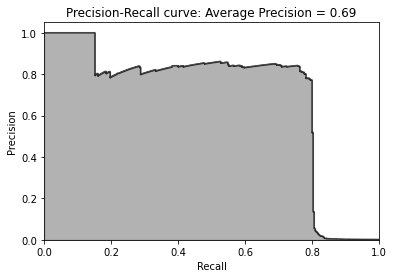

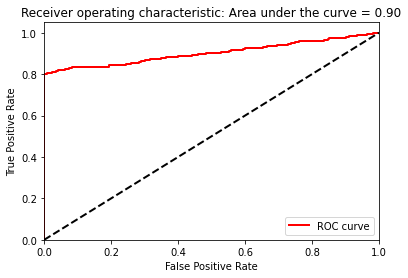

In [37]:
# View plot
anomalyScoresFastICA = anomalyScores(x_train, x_train_fastICA_inverse)
plotResults(y_train, anomalyScoresFastICA)

These results are identical to those of normal PCA. The fraud detection solution using ICA matches the best solution we’ve developed so far.

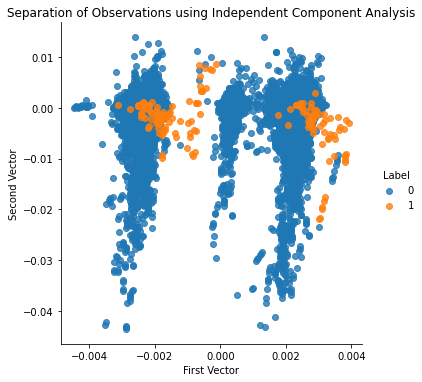

In [38]:
# Independent Component Analysis on Test Set
x_test_fastICA = fastICA.transform(x_test)
x_test_fastICA = pd.DataFrame(data=x_test_fastICA, index=x_test.index)

x_test_fastICA_inverse = fastICA.inverse_transform(x_test_fastICA)
x_test_fastICA_inverse = pd.DataFrame(data=x_test_fastICA_inverse, index=x_test.index)

scatterPlot(x_test_fastICA, y_test, "Independent Component Analysis")

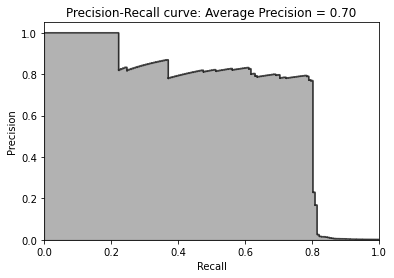

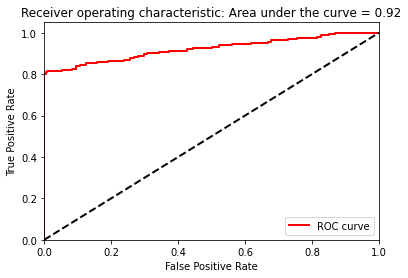

In [39]:
# View plot
anomalyScoresFastICA = anomalyScores(x_test, x_test_fastICA_inverse)
plotResults(y_test, anomalyScoresFastICA)

The results are identical to normal PCA and thus quite impressive.

### Conclusion

We used the core dimensionality reduction algorithms to develop fraud detection solutions for the credit card transactions dataset.

While not all the dimensionality reduction algorithms performed well on this credit card transactions dataset, two performed remarkably well—normal PCA and ICA.

Normal PCA and ICA caught over 80% of the known fraud with an 80% precision.

Unsupervised fraud detection systems require no labels for training, adapt well to changing fraud patterns, and can catch fraud that had gone previously undiscovered. Given these additional advantages, the unsupervised learning-based solution will generally perform better than the supervised learning-based solution at catching known and unknown or newly emerging patterns of fraud in the future, although using both in tandem is best.

***Note: The fraud labels and the evaluation metrics help us assess just how good the unsupervised fraud detection systems are at catching known patterns of fraud, that is fraud that we have caught in the past and have labels for.***

***However, we will not be able to assess how good the unsupervised fraud detection systems are at catching unknown patterns of fraud. In other words, there may be fraud in the dataset that is incorrectly labeled as not fraud because the financial company never discovered it.***

***As you may see already, unsupervised learning systems are much harder to evaluate than supervised learning systems. Often, unsupervised learning systems are judged by their ability to catch known patterns of fraud.*** 

In [40]:
### end of notebook